In [1]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
CNN_EXAMPLE_FILES = os.path.join(CURRENT_DIR, '..', 'examples', 'cnn')
VGG19_WEIGHTS_FILE = os.path.join(CNN_EXAMPLE_FILES, 'files', 'vgg19.hdf5')
IMAGE_DIR = os.path.join(CURRENT_DIR, 'caltech_101_images')

sys.path.append(CNN_EXAMPLE_FILES)

### Expected directory structure

In [2]:
os.listdir(IMAGE_DIR)[:10]

['.DS_Store',
 'beaver',
 'cougar_body',
 'gerenuk',
 'kangaroo',
 'Leopards',
 'llama',
 'okapi',
 'platypus',
 'wild_cat']

In [3]:
beaver_images = os.listdir(os.path.join(IMAGE_DIR, 'beaver'))
beaver_images[:10]

['image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0006.jpg',
 'image_0007.jpg',
 'image_0008.jpg',
 'image_0009.jpg',
 'image_0010.jpg']

## Image examples for each class

In [4]:
image_classes = [
    'beaver',
    'cougar_body',
    'gerenuk',
    'kangaroo',
    'leopards',
    'llama',
    'okapi',
    'platypus',
    'wild_cat',
]

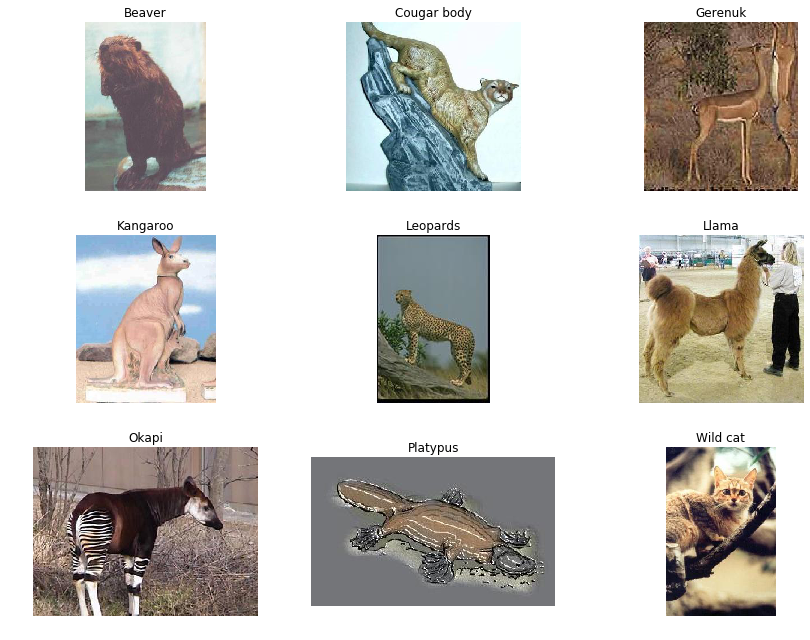

In [5]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(0)
images = []
index = 1

fig = plt.figure(figsize=(12, 9))

for name in image_classes:
    path = os.path.join(IMAGE_DIR, name)
    if index == 10:
        break
    
    if os.path.isdir(path):
        image_name = random.choice(os.listdir(path))
        image_path = os.path.join(path, image_name)
        
        image = mpimg.imread(image_path)
        
        plt.subplot(3, 3, index)
        plt.title(name.capitalize().replace('_', ' '))
        plt.imshow(image)
        plt.axis('off')
        
        index += 1
        
fig.tight_layout()

### Initializing VGG19 architecture

In [6]:
# requires also modules: requests and tqdm
from imagenet_tools import download_file, load_image, deprocess

In [7]:
from neupy import architectures
vgg19 = architectures.vgg19()
vgg19

(?, 224, 224, 3) -> [... 47 layers ...] -> (?, 1000)

### Loading pre-trained parameters

In [8]:
import os
from neupy import storage

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url="http://neupy.s3.amazonaws.com/tensorflow/imagenet-models/vgg19.hdf5",
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights')

storage.load(vgg19, VGG19_WEIGHTS_FILE)

### Loading and pre-processing input images from Caltech-101 dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

images = []
image_paths = []

for name in tqdm(image_classes):
    path = os.path.join(IMAGE_DIR, name)
    
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = load_image(
            image_path,
            image_size=(224, 224),
            crop_size=(224, 224))

        images.append(image)
        image_paths.append(image_path)
        
images = np.concatenate(images, axis=0)
image_paths = np.array(image_paths)
images.shape

/Users/itdxer/.pyenv/versions/3.5.6/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(598, 224, 224, 3)

### Propagating images through the network

In [10]:
# Note: It's important to use dense layer, because SOFM expect to see vectors
dense_2 = vgg19.end('dense_2')
batch_size = 16

outputs = []
for batch in tqdm(range(0, len(images), batch_size)):
    output = dense_2.predict(images[batch:batch + batch_size])
    outputs.append(output)
    
dense_2_output = np.concatenate(outputs, axis=0)
dense_2_output.shape

(598, 4096)

### Initializing and training SOFM on output from VGG19 network

In [12]:
from neupy import algorithms, utils

utils.reproducible()

sofm = algorithms.SOFM(
    n_inputs=dense_2_output.shape[1],
    
    # Feature map grid is 2 dimensions and has
    # 400 output clusters (20 * 20).
    features_grid=(20, 20),
    
    # Closest neuron (winning neuron) measures
    # using cosine similarity
    distance='cos',
    
    # Sample weights from the data.
    # Every weight vector will be just a sample
    # from the input data. In this way we can
    # ensure that initialized map will cover data
    # at the very beggining.
    weight='sample_from_data',

    # Defines radius within we consider near by
    # neurons as neighbours relatively to the
    # winning neuron
    learning_radius=5,
    # Large radius is efficient only for the first
    # iterations, that's why we reduce it by 1
    # every 5 epochs.
    reduce_radius_after=5,

    # The further the neighbour neuron from the winning
    # neuron the smaller learning rate for it. How much
    # smaller the learning rate controls by the `std`
    # parameter. The smaller `std` the smaller learning
    # rate for neighboring neurons.
    std=0.1,
    # Neighbours within 
    reduce_std_after=5,
    
    # Learning rate
    step=0.001,
    # Learning rate is going to be reduced every 5 epochs
    reduce_step_after=5,

    # Shows training progress in terminal
    verbose=True,
    
    # Shuffle data samples before every training epoch
    shuffle_data=True,
)
sofm.train(dense_2_output, epochs=32)


Main information

[ALGORITHM] SOFM

[OPTION] distance = ['cosine', 'cosine_similarity']
[OPTION] features_grid = [20, 20]
[OPTION] grid_type = ['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid']
[OPTION] learning_radius = 5
[OPTION] n_inputs = 4096
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 5
[OPTION] reduce_std_after = 5
[OPTION] reduce_step_after = 5
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] std = 0.1
[OPTION] step = 0.001
[OPTION] verbose = True
[OPTION] weight = sample_data



#1 : [4 sec] train: 2.484874


#2 : [3 sec] train: 2.483680


#3 : [3 sec] train: 2.483517


#4 : [3 sec] train: 2.483492


#5 : [2 sec] train: 2.483228


#6 : [2 sec] train: 2.483225


#7 : [2 sec] train: 2.483218


#8 : [2 sec] train: 2.483234


#9 : [2 sec] train: 2.483237


#10 : [1 sec] train: 2.482975


#11 : [1 sec] train: 2.482949


#12 : [1 sec] train: 2.482946


#13 : [1 sec] train: 2.482944


#14 : [1 sec] train: 2.482940


#15 : [1 sec] train: 2.482415


#16 : [1 sec] train: 2.482387


#17 : [1 sec] train: 2.482370


#18 : [1 sec] train: 2.482365


#19 : [1 sec] train: 2.482361


#20 : [1 sec] train: 2.481666


#21 : [1 sec] train: 2.481622


#22 : [1 sec] train: 2.481582


#23 : [1 sec] train: 2.481561


#24 : [1 sec] train: 2.481543


#25 : [1 sec] train: 2.480757


#26 : [1 sec] train: 2.480704


#27 : [1 sec] train: 2.480659


#28 : [1 sec] train: 2.480621


#29 : [1 sec] train: 2.480589


#30 : [1 sec] train: 2.480561


#31 : [1 sec] train: 2.480537
#32 : [1 sec] train: 2.480515


### Visualizing SOFM

In [13]:
from __future__ import division

from scipy.misc import imread
import matplotlib.gridspec as gridspec

def draw_grid(sofm, images, output_features):
    data = images
    clusters = sofm.predict(output_features).argmax(axis=1)
    grid_height, grid_weight = sofm.features_grid
    
    plt.figure(figsize=(16, 16))

    grid = gridspec.GridSpec(grid_height, grid_weight)
    grid.update(wspace=0, hspace=0)

    for row_id in range(grid_height):
        print("Progress: {:.2%}".format(row_id / grid_weight))

        for col_id in range(grid_weight):
            index = row_id * grid_height + col_id
            clustered_samples = data[clusters == index]

            if len(clustered_samples) > 0:
                # We take the first sample, but it can be any
                # sample from this cluster (random or the one
                # that closer to the center)
                sample = deprocess(clustered_samples[0])

            else:
                # If we don't have samples in cluster then
                # it means that there is a gap in space
                sample = np.zeros((224, 224, 3))

            plt.subplot(grid[index])
            plt.imshow(sample)
            plt.axis('off')

    print("Progress: 100%")
    return sample

Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%
Progress: 100%


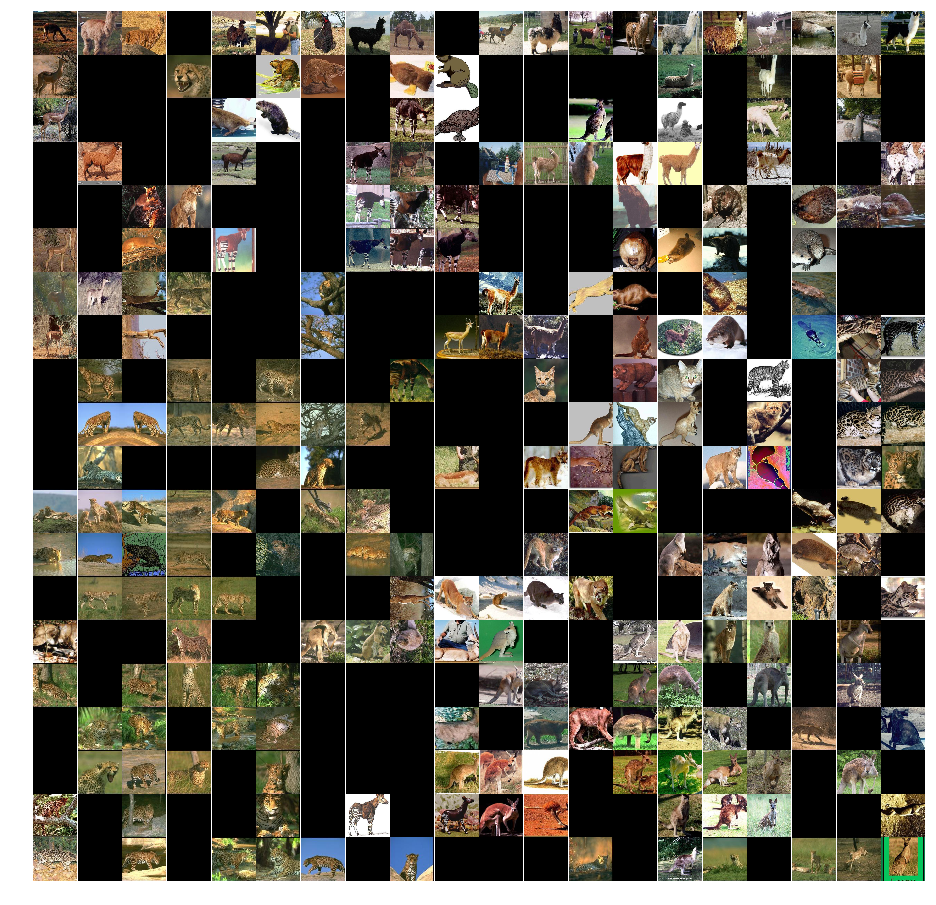

In [14]:
sample = draw_grid(sofm, images, dense_2_output)